### FWI using horizontal DAS cable.
The Porosity, Clay Content, and Water Saturation parameterization is used.

In [2]:
import segyio

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy.sparse import csr_matrix,linalg
from scipy.interpolate import interp2d
import scipy.ndimage
import scipy.io as sio

import sys
sys.path.append("../Ops/FWI")
from fwi_utils import pcs2dv_gassmann

In [18]:
font_size = 12
params = {
    'image.cmap': 'seismic',
    'axes.grid': False,
    'savefig.dpi': 300,   # to adjust notebook inline plot size
    'axes.labelsize': font_size, # fontsize for x and y labels (was 10)
    'axes.titlesize': font_size,
    'font.size': font_size, 
    'legend.fontsize': font_size,
    'xtick.labelsize': font_size,
    'ytick.labelsize': font_size
}
plt.rcParams.update(params)

In [14]:
# Download the Marmousi2 model to ./Model
!wget https://s3.amazonaws.com/open.source.geoscience/open_data/elastic-marmousi/elastic-marmousi-model.tar.gz

# Unzip the Marmousi2 model
!tar -xvf elastic-marmousi-model.tar.gz
!tar -xvf ./elastic-marmousi-model/model/MODEL_DENSITY_1.25m.segy.tar.gz
!tar -xvf ./elastic-marmousi-model/model/MODEL_P-WAVE_VELOCITY_1.25m.segy.tar.gz
!tar -xvf ./elastic-marmousi-model/model/MODEL_S-WAVE_VELOCITY_1.25m.segy.tar.gz

# mv the model to ./Models
!mv *.segy ./Models

# read the unnecessory model 
!rm -rf elastic-marmousi-model
!rm -rf elastic-marmousi-model.tar.gz

--2023-05-22 17:52:35--  https://s3.amazonaws.com/open.source.geoscience/open_data/elastic-marmousi/elastic-marmousi-model.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.224.120, 52.217.84.94, 52.216.248.142, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.224.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153722387 (147M) [application/x-gzip]
Saving to: ‘elastic-marmousi-model.tar.gz’

elastic-marmousi-mo 100%[===================>] 146.60M  9.05MB/s    in 22s     

2023-05-22 17:52:57 (6.63 MB/s) - ‘elastic-marmousi-model.tar.gz’ saved [153722387/153722387]

x elastic-marmousi-model/model/
x elastic-marmousi-model/processed_data/SEGY-Time/Kirchhoff_PoSTM_time.segy.tar.gz
x elastic-marmousi-model/processed_data/SEGY-Time/SYNTHETIC_time.segy.tar.gz
x elastic-marmousi-model/model/LAYER_PROPERTIES.pdf
x elastic-marmousi-model/processed_data/SEGY-Depth/SYNTHETIC.segy.tar.gz
x elastic-marmousi-model/processed_data/
x elastic-marmou

In [15]:
with segyio.open("./Models/MODEL_P-WAVE_VELOCITY_1.25m.segy", "r", strict=False) as segy:
    models = np.transpose(np.array([segy.trace[trid] for trid in range(segy.tracecount)]))
    vp_all = models.astype(np.float32)

with segyio.open("./Models/MODEL_S-WAVE_VELOCITY_1.25m.segy", "r", strict=False) as segy:
    models = np.transpose(np.array([segy.trace[trid] for trid in range(segy.tracecount)]))
    vs_all = models.astype(np.float32)

with segyio.open("./Models/MODEL_DENSITY_1.25m.segy", "r", strict=False) as segy:
    models = np.transpose(np.array([segy.trace[trid] for trid in range(segy.tracecount)]))
    rho_all = models.astype(np.float32)

In [16]:
# select a subsection of the Marmousi2 model
vp = vp_all[400:1700, 1300: 3800]
vs = vs_all[400:1700, 1300: 3800]
rho = rho_all[400:1700, 1300: 3800] * 1000

# define the rock properties
a1_ = 5.5 * 1e3
a2_ = 6.9 * 1e3
a3_ = 2.2 * 1e3 
b1_ = 3.4 * 1e3
b2_ = 4.7 * 1e3
b3_ = 1.8 * 1e3

rho_c = 2.55 * 1e3
rho_q = 2.65 * 1e3
rho_w = 1.00 * 1e3
rho_h = 0.10 * 1e3

# set up rock properties using the rock physics model. 
# this part is not optimized, just for demonstration purpose
# in practice, we should set the realstic rock physics

nz, nx = vp.shape
n_elements = nz * nx
vp0 = np.copy(vp)
vs0 = np.copy(vs)

a2 = a2_ * np.ones((n_elements)) 
a3 = a3_ * np.ones((n_elements)) 
b2 = b2_ * np.ones((n_elements)) 
b3 = b3_ * np.ones((n_elements)) 
y1 = a1_ - vp0
y2 = b1_ - vs0

b = np.hstack((y1.reshape(-1), y2.reshape(-1))) 
a_diag = np.arange(2*n_elements)
a_first = np.arange(n_elements)
a_second = np.arange(n_elements, 2*n_elements)    
row = np.hstack((a_diag, a_first, a_second))
col = np.hstack((a_diag, a_second, a_first))
data = np.hstack((a2, b3, a3, b2))
a = csr_matrix((data, (row, col)), dtype=np.float32)
x = linalg.spsolve(a, b)

phi = x[:n_elements].reshape(nz, nx)
cc = x[n_elements:].reshape(nz, nx)

# set up models (not realstic, just for testing purpose)
# I try to reflect the rock physics model in the models
phi_new = phi ** 0.05
phi_new = 0.05 + ((0.31 - 0.005) * (phi_new - np.min(phi_new)) / (np.max(phi_new) - np.min(phi_new)))
cc_new  = cc-cc.min()
cc_new  = cc_new**2
cc_new  = 0.13 + ((0.45 - 0.13) * (cc_new - np.min(cc_new)) / (np.max(cc_new) - np.min(cc_new)))
sw_new = rho ** 8
sw_new  = 0.34 + ((0.73 - 0.34) * (sw_new - np.min(sw_new)) / (np.max(sw_new) - np.min(sw_new)))

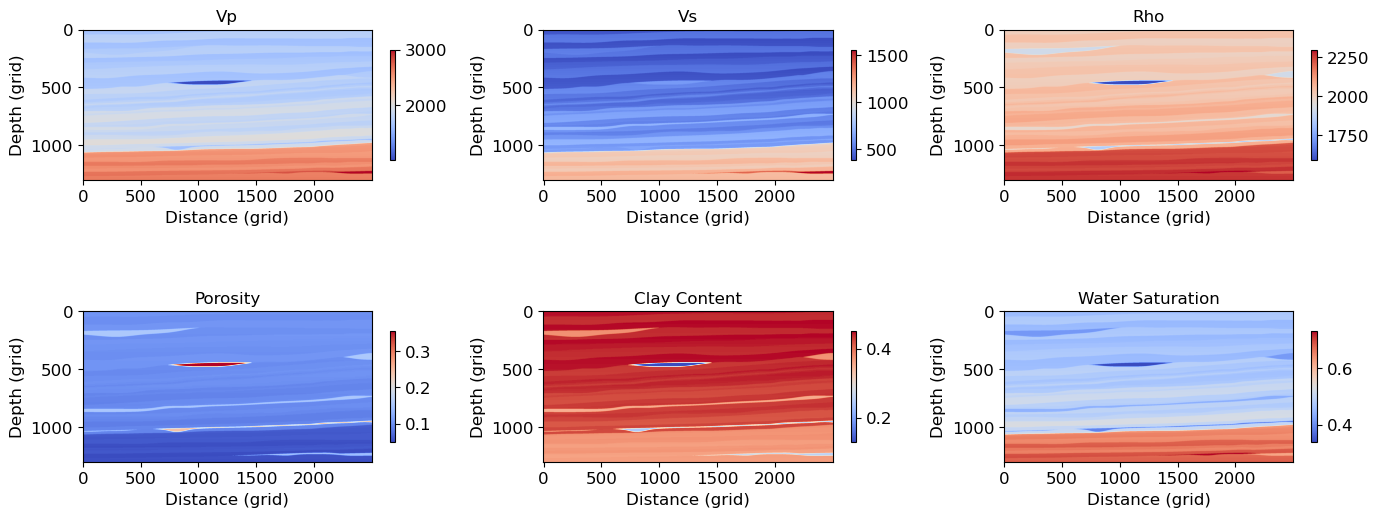

In [19]:
# view the model
title = ['Vp', 'Vs', 'Rho', 'Porosity', 'Clay Content', 'Water Saturation']
data = [vp, vs, rho, phi_new, cc_new, sw_new]
fig = plt.figure(figsize=(14, 6))
for i in range(6):
    ax = fig.add_subplot(2, 3, (i+1))
    im = ax.imshow(data[i], cmap ='coolwarm')
    fig.colorbar(im, shrink=0.4)
    ax.set_aspect('equal')
    plt.title(title[i])
    plt.xlabel('Distance (grid)')
    plt.ylabel('Depth (grid)')

plt.tight_layout()

In [10]:
# interpolate the model to the new size for the finite difference modeling and inversion
nx = 321
nz = 201
dx = 10.
dz = 10.
new_shape = (nz, nx)
x = np.arange(0, nx * dx, dx)
z = np.arange(0, nz * dz, dz)

model = []
for arr in [phi_new, cc_new, sw_new]:
    interp_func = interp2d(np.arange(arr.shape[0]), np.arange(arr.shape[1]), arr.T, kind='linear')
    interp_arr = interp_func(np.linspace(0, arr.shape[0]-1, new_shape[0]), np.linspace(0, arr.shape[1]-1, new_shape[1]))
    model.append(interp_arr)

# baseline model
phi_bl = model[0]
cc_bl  = model[1]
sw_bl  = model[2]

# monitor model: only change the water saturation, i.e., increase by 25 %
phi_ml = phi_bl.copy()
cc_ml = cc_bl.copy()
sw_ml = sw_bl.copy()
sw_ml[sw_bl < sw_bl.min() + 0.001]  *= 1.25

In [11]:
# save baseline model
np.savetxt('./Models/Baseline_phi_320_200.txt', phi_bl)
np.savetxt('./Models/Baseline_cc_320_200.txt', cc_bl)
np.savetxt('./Models/Baseline_sw_320_200.txt', sw_bl)

# save monitor model
np.savetxt('./Models/Monitor_phi_320_200.txt', phi_ml)
np.savetxt('./Models/Monitor_cc_320_200.txt', cc_ml)
np.savetxt('./Models/Monitor_sw_320_200.txt', sw_ml)

### FWI using Porosity, Clay Content, and Water Saturation parameterization

In [8]:
# clean up previous data
! rm -r /scratch/users/haipeng/Rock-Physics

In [9]:
# run forward simulation to generate obs data
! python Main-004-FWI-Rock-Physics.py --generate_data --ngpu 4

Detected CUDA files, patching ldflags
Emitting ninja build file /home/users/haipeng/TorchFWI/Ops/FWI/Src/build/build.ninja...
Building extension module fwi...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module fwi...
vp_true_pad shape = (288, 385)
End of Data Generation


In [10]:
# run FWI using the Lambda, Mu, and Density parameterization
! python Main-004-FWI-Rock-Physics.py --nIter 20 --ngpu 4

Detected CUDA files, patching ldflags
Emitting ninja build file /home/users/haipeng/TorchFWI/Ops/FWI/Src/build/build.ninja...
Building extension module fwi...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module fwi...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        64521     M =            5
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24387D+05    |proj g|=  2.01692D+04

At iterate    1    f=  2.84904D+04    |proj g|=  5.28675D+03

At iterate    2    f=  2.38101D+04    |proj g|=  4.62501D+03

At iterate    3    f=  2.00091D+04    |proj g|=  4.76702D+03

At iterate    4    f=  1.74676D+04    |proj g|=  4.55293D+03

At iterate    5    f=  1.50603D+04    |proj g|=  4.40495D+03

At iterate    6    f=  1.34329D+04    |proj g|=  4.03170D+03

At iterate    7    f=  1.26671D+04    |

### FWI using Vp, Vs, and Density parameterization

In [12]:
! rm -r /scratch/users/haipeng/Rock-Physics-NO-PCS

In [13]:
# run forward simulation to generate obs data
! python Main-005-FWI-Rock-Physics-NO-PCS.py --generate_data --ngpu 4

Detected CUDA files, patching ldflags
Emitting ninja build file /home/users/haipeng/TorchFWI/Ops/FWI/Src/build/build.ninja...
Building extension module fwi...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module fwi...
vp_true_pad shape = (288, 385)
End of Data Generation


In [14]:
# run FWI using the Lambda, Mu, and Density parameterization
! python Main-005-FWI-Rock-Physics-NO-PCS.py --nIter 25 --ngpu 4

Detected CUDA files, patching ldflags
Emitting ninja build file /home/users/haipeng/TorchFWI/Ops/FWI/Src/build/build.ninja...
Building extension module fwi...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module fwi...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       193563     M =            5
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24388D+05    |proj g|=  3.06446D+01

At iterate    1    f=  9.01039D+04    |proj g|=  2.27010D+01

At iterate    2    f=  3.99269D+04    |proj g|=  1.14313D+01

At iterate    3    f=  3.04161D+04    |proj g|=  1.22094D+01

At iterate    4    f=  2.64808D+04    |proj g|=  1.02580D+01

At iterate    5    f=  2.52631D+04    |proj g|=  8.36739D+00

At iterate    6    f=  1.72723D+04    |proj g|=  5.19314D+00

At iterate    7    f=  9.69241D+03    |

### Plot Results

### Convert to Vp, Vs, and Rho based on Gassmann’s equation

In [24]:
vp_bl, vs_bl, rho_bl = pcs2dv_gassmann(phi_bl, cc_bl, sw_bl)
vp_ml, vs_ml, rho_ml = pcs2dv_gassmann(phi_ml, cc_ml, sw_ml)

In [25]:
# set the source and receiver
ind_src_x =   np.arange(10, nx-10, 10).astype(int) 
ind_src_z = 2*np.ones(ind_src_x.shape[0]).astype(int)
ind_rec_x =   np.arange(10, nx-10).astype(int)
ind_rec_z = 2*np.ones(ind_rec_x.shape[0]).astype(int)

src_coord = np.array([ind_src_x * dx, ind_src_z * dz]).T
das_coord = np.array([ind_rec_x * dx, ind_rec_z * dz]).T

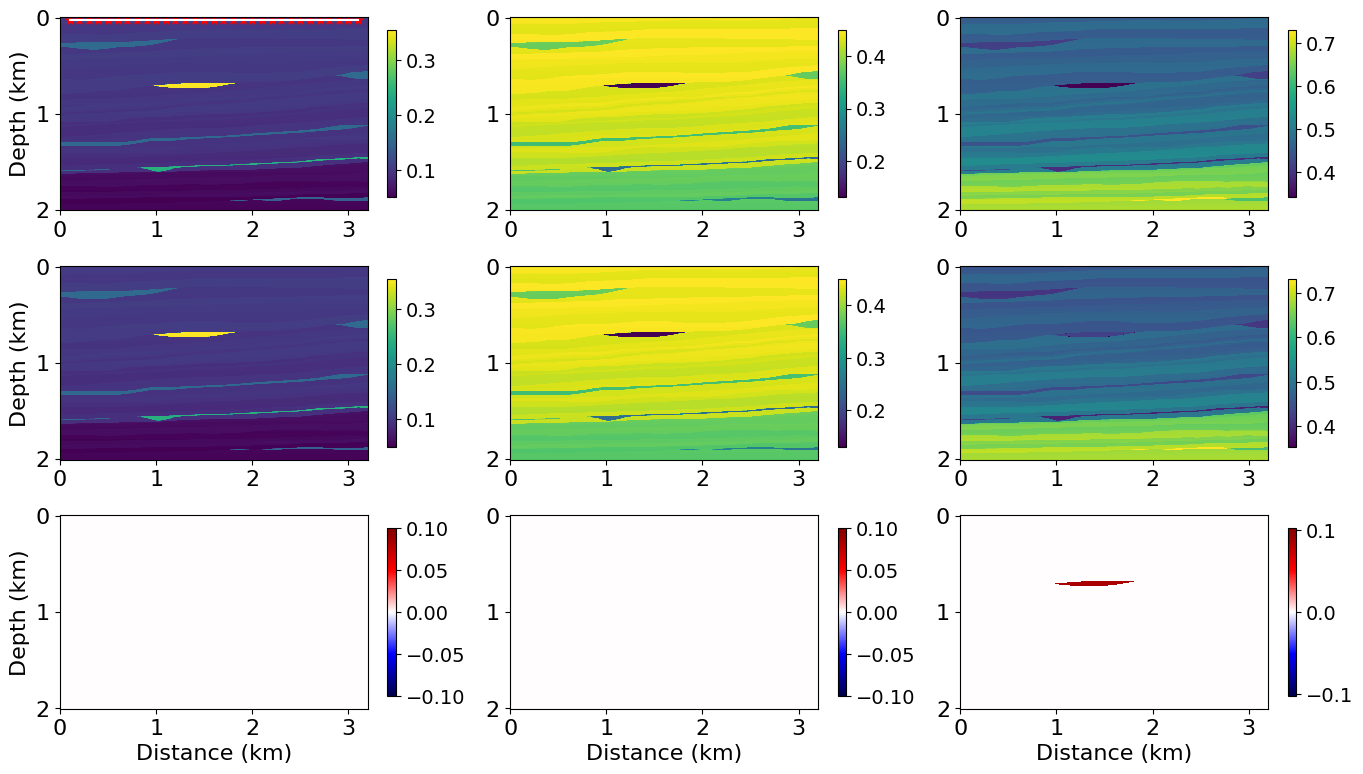

In [35]:
# PCS model
title = [ 'Porosity', 'Clay Content', 'Water Saturation', 'Vp', 'Vs', 'Density']
data = [phi_bl, cc_bl, sw_bl, phi_ml, cc_ml, sw_ml, phi_ml-phi_bl, cc_ml-cc_bl, sw_ml-sw_bl]
fig = plt.figure(figsize=(14, 8))
for i in range(9):
    ax = fig.add_subplot(3, 3, (i+1))
    if i < 6:
        im = ax.pcolor(x/1000, z/1000, data[i].T, cmap ='viridis')
    else:
        clip = np.max(abs(data[i])) * 1.2
        im = ax.pcolor(x/1000, z/1000, data[i].T, vmin=-clip, vmax=clip, cmap ='seismic')
        
    if i == 0:
        ax.plot(das_coord[:,0]/1000, das_coord[:,1]/1000, 'w-', linewidth=1.5)
        ax.scatter(ind_src_x * dx/1000, ind_src_z * dz/1000, color='r', marker = '*')

    plt.gca().invert_yaxis()
    colorbar = fig.colorbar(im, shrink=0.8)
    colorbar.ax.tick_params(labelsize=14)
    
    ax.set_aspect('equal')
    if i > 5:
        plt.xlabel('Distance (km)')
    if i % 3 == 0:
        plt.ylabel('Depth (km)')
        
plt.tight_layout()
plt.savefig('./Fig/FWI-Rock-Physics-PCS-model.png', dpi=300, bbox_inches='tight')

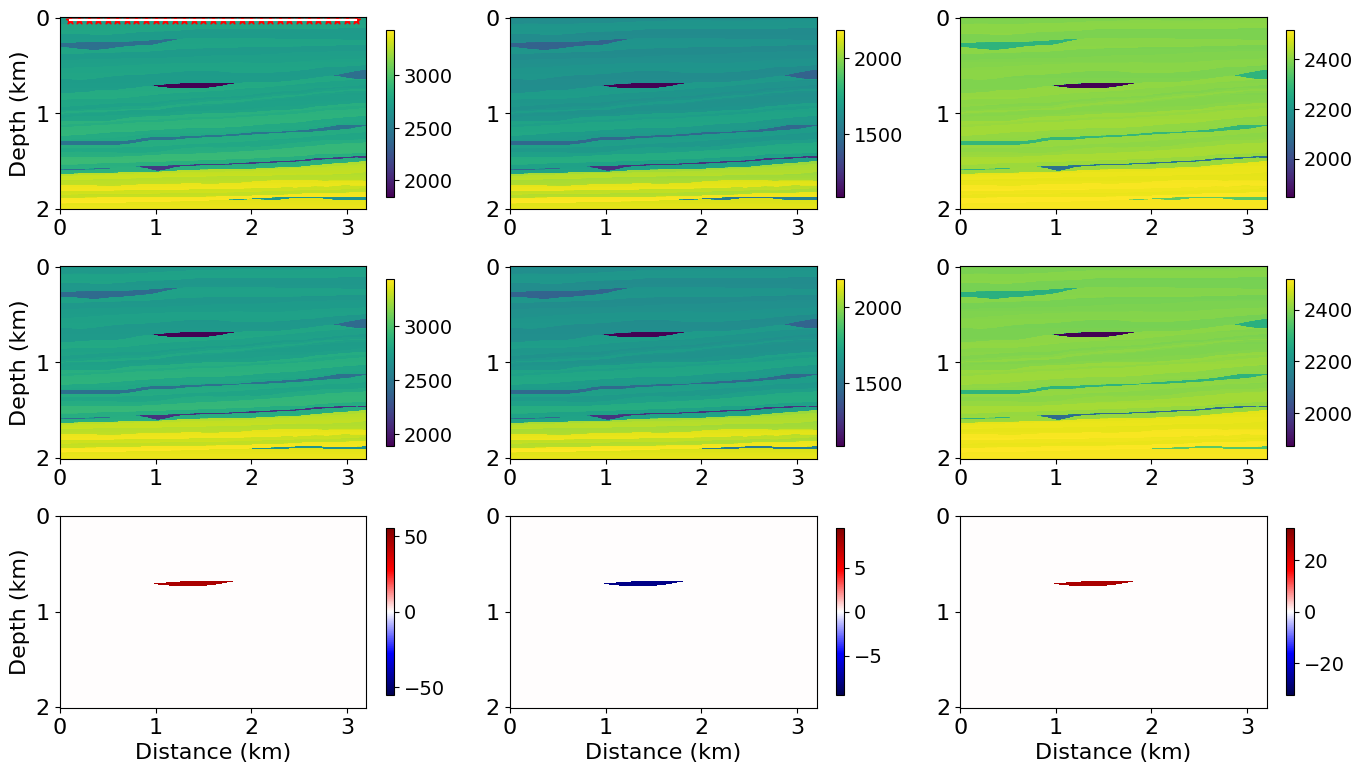

In [36]:
## baseline model
data = [vp_bl, vs_bl, rho_bl, vp_ml, vs_ml, rho_ml, vp_ml-vp_bl, vs_ml-vs_bl, rho_ml-rho_bl]
fig = plt.figure(figsize=(14, 8))
for i in range(9):
    ax = fig.add_subplot(3, 3, (i+1))
    if i < 6:
        im = ax.pcolor(x/1000, z/1000, data[i].T, cmap ='viridis')
    else:
        clip = np.max(abs(data[i])) * 1.2
        im = ax.pcolor(x/1000, z/1000, data[i].T, vmin=-clip, vmax=clip, cmap ='seismic')
        
    if i == 0:
        ax.plot(das_coord[:,0]/1000, das_coord[:,1]/1000, 'w-', linewidth=1.5)
        ax.scatter(ind_src_x * dx/1000, ind_src_z * dz/1000, color='r', marker = '*')

    plt.gca().invert_yaxis()
    colorbar = fig.colorbar(im, shrink=0.8)
    colorbar.ax.tick_params(labelsize=14)
    
    ax.set_aspect('equal')
    if i > 5:
        plt.xlabel('Distance (km)')
    if i % 3 == 0:
        plt.ylabel('Depth (km)')

plt.tight_layout()
plt.savefig('./Fig/FWI-Rock-Physics-model.png', dpi=300, bbox_inches='tight')

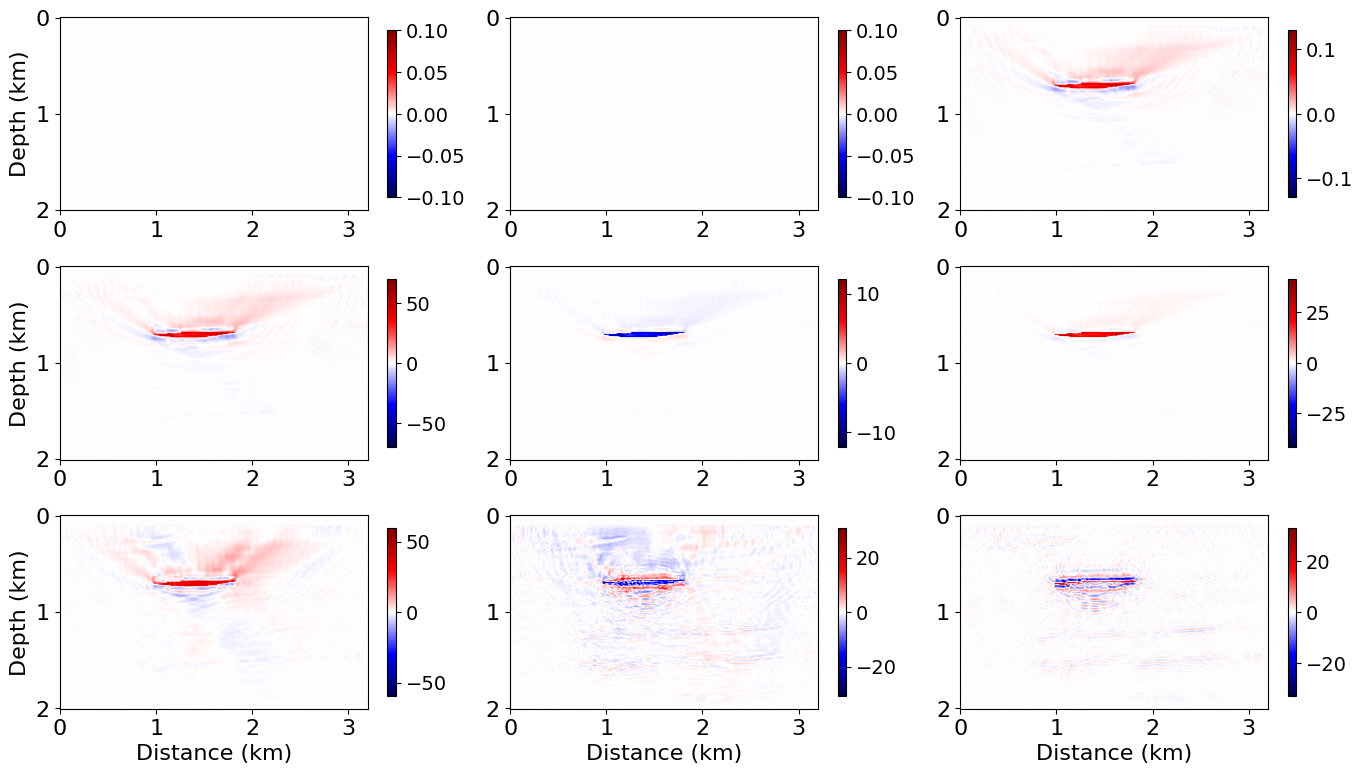

In [37]:
# load the FWI result from PCS scheme
ite = 12
work_path = '/scratch/users/haipeng/Rock-Physics'
sw_fwi_pcs  = sio.loadmat(work_path + f'/Results/SW{ite}.mat')['SW'].T
vp_fwi_pcs, vs_fwi_pcs, rho_fwi_pcs = pcs2dv_gassmann(phi_bl, cc_bl, sw_fwi_pcs)


# load the FWI result from Vp, Vs, density scheme
ite = 24
work_path = '/scratch/users/haipeng/Rock-Physics-NO-PCS'
vp_fwi  = sio.loadmat(work_path + f'/Results/Vp{ite}.mat')['Vp'].T
vs_fwi  = sio.loadmat(work_path + f'/Results/Vs{ite}.mat')['Vs'].T
rho_fwi = sio.loadmat(work_path + f'/Results/Den{ite}.mat')['Den'].T

data = [phi_ml-phi_bl, cc_ml-cc_bl, sw_fwi_pcs-sw_bl, vp_fwi_pcs-vp_bl, vs_fwi_pcs-vs_bl, rho_fwi_pcs-rho_bl, vp_fwi-vp_bl, vs_fwi-vs_bl, rho_fwi-rho_bl]

fig = plt.figure(figsize=(14, 8))
for i in range(9):
    ax = fig.add_subplot(3, 3, (i+1))
    # clip = np.percentile(data[i], 0.90)
    clip = np.max(abs(data[i])) * 1.2
    im = ax.pcolor(x/1000, z/1000, data[i].T, cmap ='seismic', vmin = -clip, vmax= clip)

    plt.gca().invert_yaxis()
    colorbar = fig.colorbar(im, shrink=0.8)
    colorbar.ax.tick_params(labelsize=14)
    
    ax.set_aspect('equal')
    if i > 5:
        plt.xlabel('Distance (km)')
    if i % 3 == 0:
        plt.ylabel('Depth (km)')
        
plt.tight_layout()
plt.savefig('./Fig/FWI-Rock-Physics-Result.png', dpi=300, bbox_inches='tight')

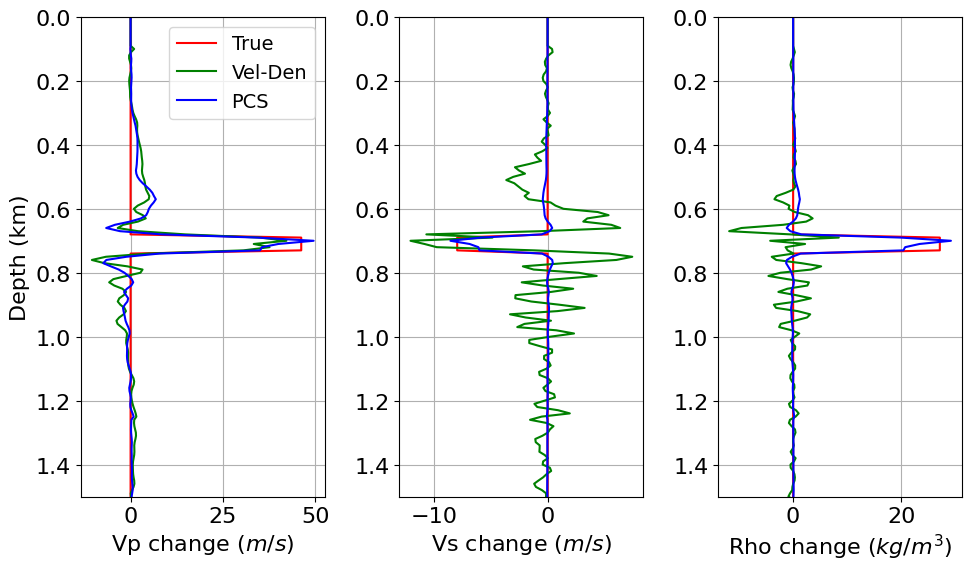

In [47]:
fig = plt.figure(figsize=(10, 6))
ind = 150
plt.subplot(1,3,1)
plt.plot(vp_ml[ind,:]      - vp_bl[ind,:], z/1000, 'r-')
plt.plot(vp_fwi[ind,:]     - vp_bl[ind,:], z/1000, 'g-')
plt.plot(vp_fwi_pcs[ind,:] - vp_bl[ind,:], z/1000, 'b-')
plt.ylim([0, 1.5])
plt.gca().invert_yaxis()
plt.legend(['True', 'Vel-Den', 'PCS'], loc='upper right', fontsize = 14)
plt.ylabel('Depth (km)')
plt.xlabel('Vp change ($m/s$)')
plt.grid()

plt.subplot(1,3,2)
plt.plot(vs_ml[ind,:]      - vs_bl[ind,:], z/1000, 'r-')
plt.plot(vs_fwi[ind,:]     - vs_bl[ind,:], z/1000, 'g-')
plt.plot(vs_fwi_pcs[ind,:] - vs_bl[ind,:], z/1000, 'b-')
plt.ylim([0, 1.5])
plt.gca().invert_yaxis()
plt.xlabel('Vs change ($m/s$)')
plt.grid()

plt.subplot(1,3,3)
plt.plot(rho_ml[ind,:]      - rho_bl[ind,:], z/1000, 'r-')
plt.plot(rho_fwi[ind,:]     - rho_bl[ind,:], z/1000, 'g-')
plt.plot(rho_fwi_pcs[ind,:] - rho_bl[ind,:], z/1000, 'b-')
plt.ylim([0, 1.5])
plt.gca().invert_yaxis()
plt.xlabel('Rho change ($kg/m^3$)')
plt.grid()

plt.tight_layout()
plt.savefig('./Fig/FWI-Rock-Physics-Result2.png', dpi=300, bbox_inches='tight')

In [48]:
# work_path = '/scratch/users/haipeng/Rock-Physics'

# dt = 0.001
# nt = 4001

# sg1 = np.fromfile(f'{work_path}/Data/Shot_ett{3}.bin',  dtype=np.float32).reshape(-1, nt)
# sg2 = np.fromfile(f'{work_path}/Data/Shot_ett{10}.bin', dtype=np.float32).reshape(-1, nt)
# sg3 = np.fromfile(f'{work_path}/Data/Shot_ett{18}.bin', dtype=np.float32).reshape(-1, nt)

# t = np.arange(0, nt)*dt
# off = np.arange(np.size(ind_rec_x))

# fig = plt.figure(figsize=(12, 12))
# for i, sg in enumerate([sg1, sg2, sg3]):
#     plt.subplot(1,3,i+1)
#     clim = np.percentile(np.absolute(sg), 95)
#     plt.imshow(sg.T, aspect=0.1, cmap='gray', vmin = -clim, vmax=clim)
#     plt.yticks(np.arange(0,  nt + 100, 1000), np.arange(0,  nt + 100, 1000) * dt)
#     plt.xlabel('Traces')
#     plt.ylabel('Time (s)')
    
# plt.tight_layout()
# # plt.savefig('./Fig/003-FWI-Marmousi-true-data-pre-marine.png', dpi=300, bbox_inches='tight')

In [49]:
# ## Smooth the baseline model a bit

# # smooth the model
# phi_bl_sm = scipy.ndimage.gaussian_filter(phi_bl, sigma=4, order=0)
# cc_bl_sm = scipy.ndimage.gaussian_filter(cc_bl, sigma=4, order=0)
# sw_bl_sm = scipy.ndimage.gaussian_filter(sw_bl, sigma=4, order=0)


# ## changes
# title = [ 'Porosity', 'Clay Content', 'Water Saturation', 'Vp', 'Vs', 'Rho']
# data = [phi_bl_sm, cc_bl_sm, sw_bl_sm, vp_bl_sm, vs_bl_sm, rho_bl_sm]
# fig = plt.figure(figsize=(14, 6))
# for i in range(6):
#     ax = fig.add_subplot(2, 3, (i+1))
#     im = ax.pcolor(x/1000, z/1000, data[i].T, cmap ='coolwarm')
#     fig.colorbar(im, shrink=0.7)
#     plt.gca().invert_yaxis()
#     ax.set_aspect('equal')
#     plt.title(title[i])
#     if i == 0:
#         plt.scatter(das_coord[:,0]/1000, das_coord[:,1]/1000, color='k', marker = '.')
#         plt.scatter(src_coord[:,0]/1000, src_coord[:,1]/1000, color='r', marker = '*')
#     if i >= 3:
#         plt.xlabel('Distance (km)')
#     if i % 3 == 0:
#         plt.ylabel('Depth (km)')

# plt.tight_layout()
# plt.savefig('FWI-Rock-Physics-difference-smooth-model.png', dpi=300, bbox_inches='tight')